In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import utils
from whitelists import *
import top_crates

# Configure pyplot: enlarge plots 
plt.rcParams['figure.figsize'] = [15, 8]
# Configure pandas: show all columns when printing a dataframe
pd.set_option('display.max_columns', None)
# Configure pandas: show more rows when printing a dataframe
pd.set_option('display.min_rows', 20)

In [2]:
# Load tables
function_definitions = utils.load_selected_function_definitions()
raw_function_unsafe_reasons = utils.load_unsafe_reasons_in_function_definitions()
unsafe_block_calls = utils.load_unsafe_block_calls()
const_calls = utils.load_const_calls()
unsafe_blocks = utils.load_unsafe_blocks()
traits = utils.load_selected_traits()
traits_impls = utils.load_selected_impl_definitions()
type_defs = utils.load_selected_type_defs()
adts = utils.load_selected_adts()
adt_field_types = utils.load_selected_adt_field_types()
selected_builds = utils.load_selected_builds()

In [3]:
# Cleanup: remove duplicates
raw_function_unsafe_reasons = raw_function_unsafe_reasons.drop_duplicates()

# Remove functions that are not in function_definitions
raw_function_unsafe_reasons = raw_function_unsafe_reasons[
    raw_function_unsafe_reasons.def_path.isin(set(function_definitions.def_path.unique()))
]

possible_unsafe_reasons = [
    "call to unsafe function",
    "use of inline assembly",
    "initializing type with `rustc_layout_scalar_valid_range` attr",
    "cast of pointer to int",
    "pointer operation",
    "borrow of packed field",
    "use of mutable static",
    "use of extern static",
    "dereference of raw pointer",
    "assignment to non-`Copy` union field",
    "access to union field",
    "mutation of layout constrained field",
    "borrow of layout constrained field with interior mutability",
]

# Map reasons -> number
function_unsafe_reasons = raw_function_unsafe_reasons[
    ["crate_name", "crate_hash", "def_path", "unsafe_reason"]
].groupby("def_path").agg(frozenset).rename(
    columns={'unsafe_reason': 'unsafe_reasons'}
)

function_unsafe_reasons["unsafe_reasons_vec"] = function_unsafe_reasons.unsafe_reasons.map(
    lambda x: [reason in x for reason in possible_unsafe_reasons]
)
function_unsafe_reasons["num_unsafe_reasons"] = function_unsafe_reasons.unsafe_reasons_vec.map(sum)

for reason in possible_unsafe_reasons:
    function_unsafe_reasons[reason] = function_unsafe_reasons.unsafe_reasons.map(
        lambda x: reason in x
    )

# Augment const calls made from unsafe blocks
unsafe_block_const_calls = unsafe_block_calls.join(
    const_calls.set_index("call"),
    on="call",
    how="inner",
    rsuffix="_defsite",
)
# Rename confusing columns
unsafe_block_const_calls.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)

# Preprocessing
unsafe_function_definitions = function_definitions[function_definitions.unsafety == "Unsafe"]

ForeignItem    3478
Rust           2699
C               176
Name: abi, dtype: int64
ForeignItem    54.745789
Rust           42.483866
C               2.770345
Name: abi, dtype: float64
Unsafe function definitions: 6353


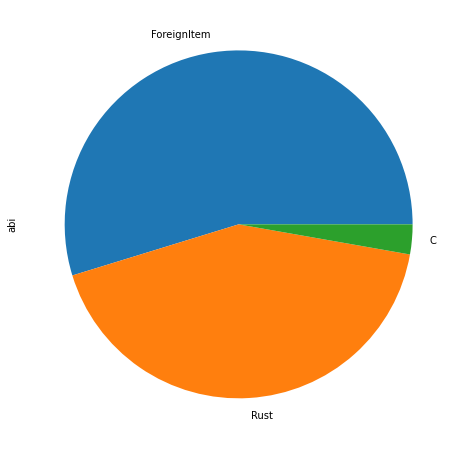

In [4]:
# Frequency of abi
values = unsafe_function_definitions.abi.value_counts()
print(values)
print(values / len(unsafe_function_definitions) * 100)
print("Unsafe function definitions:", len(unsafe_function_definitions))
values.plot.pie()
del values

In [5]:
# Which crates call C functions?
c_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'C' in s.abi:
        c_funcs.append(s.crate)

c_funcs = list(dict.fromkeys(c_funcs))

print("Number of crates that call C functions:\t", len(c_funcs))
print("Unique crate names:")

for crate in c_funcs:
    print("\t" + crate)

Number of crates that call C functions:	 7
Unique crate names:
	backtrace
	libc
	wasm_bindgen
	miniz_oxide_c_api
	security_framework
	openssl
	ring


In [6]:
# Which crates call foreign functions?
f_funcs = []
for i, s in unsafe_function_definitions.iterrows():
    if 'ForeignItem' in s.abi:
        f_funcs.append(s.crate)

f_funcs = list(dict.fromkeys(f_funcs))

print("Number of crates that call foreign functions:\t", len(f_funcs))
print("Unique crate names:")

for crate in f_funcs:
    print("\t" + crate)

Number of crates that call foreign functions:	 31
Unique crate names:
	backtrace
	clang_sys
	curl_sys
	openssl_sys
	core_foundation_sys
	inotify_sys
	term_size
	libc
	fuchsia_zircon_sys
	time
	miniz_sys
	libssh2_sys
	libz_sys
	libgit2_sys
	brotli_sys
	cloudabi
	xattr
	termios
	bzip2_sys
	libsqlite3_sys
	security_framework_sys
	backtrace_sys
	errno
	libloading
	crypto
	lzma_sys
	wasi
	fuchsia_cprng
	hermit_abi
	termion
	ring


In [7]:
# SIMD const calls total
const_calls_loaded = utils.load_const_calls()
const_calls_loaded.rename(
    columns={"crate_name": "crate_callsite", "crate": "crate_defsite"},
    inplace=True
)
simd_functions = set([
    x
    for x in const_calls_loaded.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
simd_calls = const_calls_loaded[
    const_calls_loaded.def_path.isin(simd_functions)
]

# SIMD const calls unsafe only
unsafe_simd_functions = set([
    x
    for x in unsafe_block_const_calls.def_path.unique()
    if x.startswith('core[7bab]::core_arch')
])
unsafe_simd_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unsafe_simd_functions)
]

# Both should be equal since can only call SIMD in unsafe blocks
assert len(unsafe_simd_calls) == len(simd_calls)

print("Total number of SIMD calls:\t", len(simd_calls))
simd_calls

Total number of SIMD calls:	 391


,build,package_name,package_version,crate_callsite,build_crate_hash,edition,crate_defsite,crate_hash,def_path,def_path_hash,summary_key,block,unsafe_scope,check_mode,call,unsafety,abi
4078,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,5b520ae141c939b65e6d8047603a4531,core.core_arch.x86.sse2._mm_loadu_si128,886186,359128,UnsafeBlockUserProvided,289580,Unsafe,Rust
4080,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,d050b45b4177fc9af97599306a448662,core.core_arch.x86.sse2._mm_movemask_epi8,886191,359128,UnsafeBlockUserProvided,289582,Unsafe,Rust
4092,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,55e80d4a4b1814f1a81643982b7ee72f,core.core_arch.x86.sse2._mm_load_si128,886220,359128,UnsafeBlockUserProvided,289594,Unsafe,Rust
4094,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,55e80d4a4b1814f1a81643982b7ee72f,core.core_arch.x86.sse2._mm_load_si128,886222,359128,UnsafeBlockUserProvided,289596,Unsafe,Rust
4096,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,55e80d4a4b1814f1a81643982b7ee72f,core.core_arch.x86.sse2._mm_load_si128,886225,359128,UnsafeBlockUserProvided,289598,Unsafe,Rust
4098,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,55e80d4a4b1814f1a81643982b7ee72f,core.core_arch.x86.sse2._mm_load_si128,886228,359128,UnsafeBlockUserProvided,289600,Unsafe,Rust
4099,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,aa82e21054c08158a84fb30b99b0032,core.core_arch.x86.sse2._mm_or_si128,886229,359128,UnsafeBlockUserProvided,289601,Unsafe,Rust
4100,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,aa82e21054c08158a84fb30b99b0032,core.core_arch.x86.sse2._mm_or_si128,886230,359128,UnsafeBlockUserProvided,289602,Unsafe,Rust
4101,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,aa82e21054c08158a84fb30b99b0032,core.core_arch.x86.sse2._mm_or_si128,886231,359128,UnsafeBlockUserProvided,289603,Unsafe,Rust
4102,238,bstr,0.2.13,bstr,45c0d8d35cd08ea3,2015,core,315ae723559ff6e7,core[7bab]::core_arch[0]::x86[0]::sse2[0]::_mm...,d050b45b4177fc9af97599306a448662,core.core_arch.x86.sse2._mm_movemask_epi8,886232,359128,UnsafeBlockUserProvided,289604,Unsafe,Rust


In [8]:
# Get names of unique SIMD-calling crates
simd_crates = simd_calls.crate_callsite.unique()

print("Number of crates that call SIMD functions:\t", len(simd_crates))
print("Crates that call SIMD functions:\n\t", simd_crates)

Number of crates that call SIMD functions:	 7
Crates that call SIMD functions:
	 ['bstr' 'hashbrown' 'ahash' 'ppv_lite86' 'sha2' 'sha1' 'rdrand']


In [9]:
# Count functions with assembly code, per crate
asm_fns = function_unsafe_reasons[function_unsafe_reasons["use of inline assembly"]]
print("Number of functions using inline assembly:\t", len(asm_fns))
if len(asm_fns) > 0:
    values = asm_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with inline assembly among 10 top crates:', sum(values[:10])/len(asm_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    asm_fns
    del values

Number of functions using inline assembly:	 0


In [10]:
# Whitelists
all_function_names = set(function_definitions.def_path.unique())
unchecked_function_names = get_unchecked_function_names(all_function_names)
unguarded_function_names = get_unguarded_function_names(all_function_names)

all_calls = utils.load_all_calls()

unsafe_calls = all_calls.query("unsafety != 'Normal'")
assert len(pd.unique(unsafe_calls.unsafety)) == 1

In [11]:
# Unchecked functions
print("unchecked_function_names:", len(unchecked_function_names))

unchecked_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unchecked_function_names)
]
print("Calls to unchecked functions:", len(unchecked_calls))
print("Percentage:", len(unchecked_calls)/len(unsafe_calls)*100)

values = unchecked_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

# Used in Sec. 6.2
print("Percentage of unsafe blocks with an unchecked function call:",
    len(unchecked_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unchecked_function_names: 366
Calls to unchecked functions: 93
Percentage: 0.0967812431706784
Number of crates: 23
Percentage: 4.509803921568627
(http, 6808a9d62e774206)         14
(json, 79b54c8356a47b67)         14
(pest, 90a091c6ae19edc6)          8
(criterion, 8abcfaebda0e558c)     7
(bytecount, f10097f5caefdc70)     6
dtype: int64
Percentage of unsafe blocks with an unchecked function call: 0.7737119970872018


In [12]:
# Unguarded functions
print("unguarded_function_names:", len(unguarded_function_names))

unguarded_calls = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(unguarded_function_names)
]
print("Calls to unguarded functions:", len(unguarded_calls))
print("Percentage:", len(unguarded_calls)/len(unsafe_calls)*100)

values = unguarded_calls[['crate_callsite', 'build_crate_hash']].apply(
    lambda row: (row['crate_callsite'], row['build_crate_hash']), axis=1
).squeeze().value_counts()
print("Number of crates:", len(values))
print("Percentage:", len(values)/len(selected_builds)*100)
print(values[:5])

print("Percentage of unsafe blocks with an unguarded function call:",
     len(unguarded_calls.unsafe_scope.unique())/len(unsafe_block_const_calls.unsafe_scope.unique())*100
)
del values

unguarded_function_names: 0
Calls to unguarded functions: 0
Percentage: 0.0
Number of crates: 0
Percentage: 0.0
Series([], dtype: int64)
Percentage of unsafe blocks with an unguarded function call: 0.0


In [13]:
# Pointer operations (not just dereferences)
all_unsafe_function_names = set(unsafe_function_definitions.def_path.unique())
all_safe_function_names = set(function_definitions[function_definitions.unsafety == "Normal"].def_path.unique())
all_closure_names = set(function_definitions[function_definitions.unsafety == "Unknown"].def_path.unique())
assert len(all_unsafe_function_names) > 0
assert len(all_safe_function_names) > 0
assert len(all_closure_names) > 0

print("all_unsafe_function_names:", len(all_unsafe_function_names))
print("all_safe_function_names:", len(all_safe_function_names))
print("all_closure_names:", len(all_closure_names))

count1 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_unsafe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("unsafe functions with a pointer operation:", count1, 100 * count1 / len(all_unsafe_function_names))

count2 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_safe_function_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("safe functions with a pointer operation:", count2, 100 * count2 / len(all_safe_function_names))

count3 = sum(function_unsafe_reasons[
    function_unsafe_reasons.index.isin(all_closure_names)
]["pointer operation"])    # FIXME what is classified as a pointer operation?
print("closures with a pointer operation:", count3, 100 * count3 / len(all_closure_names))

all_unsafe_function_names: 6353
all_safe_function_names: 100879
all_closure_names: 12921
unsafe functions with a pointer operation: 0 0.0
safe functions with a pointer operation: 0 0.0
closures with a pointer operation: 0 0.0


In [14]:
# Count functions with pointer operations (another method)
ptr_op_fns = function_unsafe_reasons[function_unsafe_reasons["pointer operation"]]
print("Number of functions using pointer operations:", len(ptr_op_fns))
if len(ptr_op_fns) > 0:
    values = ptr_op_fns[['crate_name', 'crate_hash']].apply(
        lambda row: (row['crate_name'], row['crate_hash']), axis=1
    ).squeeze().value_counts()
    print("Number of crates:", len(values))
    print()
    print('Percentage of functions with pointer operations among 10 top crates:', sum(values[:10])/len(ptr_op_fns)*100)
    print("Such functions per crate:")
    print(values[:10])
    ptr_op_fns
    del values

Number of functions using pointer operations: 0


In [15]:
# How many calls to performance-motivated intrinsic functions
defs = []
for i, s in unsafe_block_const_calls.iterrows():
    if s.def_path.startswith('core[7bab]::intrinsics[0]'):
        defs.append(s.def_path)
        
defs = list(dict.fromkeys(defs))
#for d in defs:
#    print(d)
del defs

blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::intrinsics[0]::[1]::transmute[0]',
        'core[7bab]::intrinsics[0]::write_bytes[0]',
        'core[7bab]::intrinsics[0]::copy[0]',
        'core[7bab]::intrinsics[0]::copy_nonoverlapping[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 469 11333 4.138357010500309

crates 63 12.352941176470589
cgmath                  88
ahash                   65
byteorder               40
wasm_bindgen            21
itoa                    20
cast                    20
crypto                  17
git2                    14
memchr                  12
nix                     11
                        ..
linked_hash_map          1
bumpalo                  1
block_buffer             1
futures_timer            1
tokio_current_thread     1
block_padding            1
tokio_reactor            1
scoped_threadpool        1
ordered_float            1
image                    1
Name: crate_callsite, Length: 63, dtype: int64
26 5.098039215686274

With 1000+ unsafe blocks:


In [16]:
# How many calls to performance-motivated mem functions
defs = []
for i, s in unsafe_block_const_calls.iterrows():
    if s.def_path.startswith('core[7bab]::mem[0]'):
        defs.append(s.def_path)
        
defs = list(dict.fromkeys(defs))
#for d in defs:
#    print(d)
del defs

blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::mem[0]::transmute_copy[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 8 11333 0.07059031147974941

crates 3 0.5882352941176471
crossbeam_channel     6
const_random_macro    1
ring                  1
Name: crate_callsite, dtype: int64
1 0.19607843137254902

With 1000+ unsafe blocks:


In [17]:
# How many calls to performance-motivated slice functions
defs = []
for i, s in unsafe_block_const_calls.iterrows():
    if s.def_path.startswith('core[7bab]::slice[0]'):
        defs.append(s.def_path)
        
defs = list(dict.fromkeys(defs))
#for d in defs:
#    print(d)
del defs

blocks = unsafe_block_const_calls[
    unsafe_block_const_calls.def_path.isin(set([
        'core[7bab]::slice[0]::from_raw_parts[0]',
        'core[7bab]::slice[0]::from_raw_parts_mut[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_ptr[0]',
        'core[7bab]::slice[0]::{{impl}}[0]::as_mut_ptr[0]',
    ]))
][
    ["crate_callsite", "build_crate_hash", "unsafe_scope"]
].drop_duplicates()
print("blocks", len(blocks), len(unsafe_blocks), 100 * len(blocks) / len(unsafe_blocks))
print()
print("crates", len(blocks.build_crate_hash.unique()),
      100 * len(blocks.build_crate_hash.unique()) / len(selected_builds.crate_hash.unique()))
data = pd.value_counts(blocks.crate_callsite)
print(data)
print(sum(data > 3), 100 * sum(data > 3) / len(selected_builds.crate_hash.unique()))
print()
print("With 1000+ unsafe blocks:")
for crate, count in data[data >= 1000].iteritems():
    print("* {} {}: https://crates.io/crates/{}".format(count, crate, crate))
del blocks, data

blocks 656 11333 5.7884055413394515

crates 71 13.92156862745098
openssl              119
generic_array         73
byteorder             57
ring                  49
rand                  44
nix                   38
git2                  31
encoding_rs           24
image                 13
ahash                 12
                    ... 
aho_corasick           1
sha1                   1
console                1
tar                    1
wait_timeout           1
compiletest_rs         1
crossbeam_channel      1
crossbeam_queue        1
inotify                1
bindgen                1
Name: crate_callsite, Length: 71, dtype: int64
30 5.882352941176471

With 1000+ unsafe blocks:


In [18]:
# How many calls to performance-motivated sync functions (specifically: AtomicPtr struct uses)
defs = []
for i, s in unsafe_block_const_calls.iterrows():
    if s.def_path.startswith('core[7bab]::sync[0]'):
        defs.append(s.def_path)
        
defs = list(dict.fromkeys(defs))
for d in defs:
    print(d)
del defs

core[7bab]::sync[0]::atomic[0]::{{impl}}[6]::store[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[6]::load[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::load[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::compare_and_swap[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[5]::swap[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::fetch_sub[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[5]::load[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[6]::swap[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::get_mut[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::compare_exchange[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::swap[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[5]::store[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::fetch_and[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::fetch_or[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::fetch_xor[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[69]::store[0]
core[7bab]::sync[0]::atomic[0]::{{impl}}[6]::get_mut[0]
core[7bab]::sync[0]::atomic[0]::fence